In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

# Instructions

1. Download WTI Crude Oil(DCOILWTICO) data from FRED from '2022-08-29' to '2023-11-29', read the csv using `pd.read_csv()`, clean the dataset
2. Name this .ipynb file `LastName_FirstName_HW0.ipynb`
3. Do the problems
3. Make sure the notebook runs without errors after restarting your kernel
4. Submit this .ipynb file to Blackboard in the Homework 0 file

In [2]:
df = pd.read_csv("C:\\Users\\anjal\\Desktop\\Fall 2025\\Derivatives\\Homework\\DCOILWTICO.csv")

In [3]:
df.columns

Index(['observation_date', 'DCOILWTICO'], dtype='object')

In [4]:
# Renaming columns 
df = df.rename(columns={
    "observation_date": "observation_dates",
    "DCOILWTICO": "price_per_barrel"
})

In [5]:
# Checking for missing data
df.isnull().value_counts()

observation_dates  price_per_barrel
False              False               314
                   True                 14
Name: count, dtype: int64

In [6]:
# Handling missing data with forward filling 
df.ffill(inplace=True)

In [7]:
df.dtypes

observation_dates     object
price_per_barrel     float64
dtype: object

In [8]:
# Changing datatype for date column
df["observation_dates"] = pd.to_datetime(df["observation_dates"])

# Part A — Forwards: Hedge an Oil Producer

**Scenario:** You expect to sell **5,000 barrels** of oil in **3 months**. Compare potential outcomes:
- **Unhedged revenue:** `2,000 × S_T`
- **Hedged revenue with short forward:** `2,000 × K`

**Tasks**
1. Make a copy of your dataframe and slice it from '2022-08-29' to '2022-11-29'
- Assume Forward Price at $t_0=S_0$
- `T = '2022-11-29'`
2. Plot WTI spot path from `t0` to `T` and report `S_0` and `S_T`.
3. Compute P&L for **short** forward per barrel and scaled by 5,000 bbl.
4. Compare hedged vs unhedged revenue and discuss hedge effectiveness (2–4 sentences).
5. Plot the theoretical P&L of a long forward and a short forward with $K = S_0$


In [9]:
df_3mths = df.copy()

# Slice between dates
df_3mths = df.copy()[
    (df["observation_dates"] >= "2022-08-29") &
    (df["observation_dates"] <= "2022-11-29")
]

<Figure size 640x480 with 0 Axes>

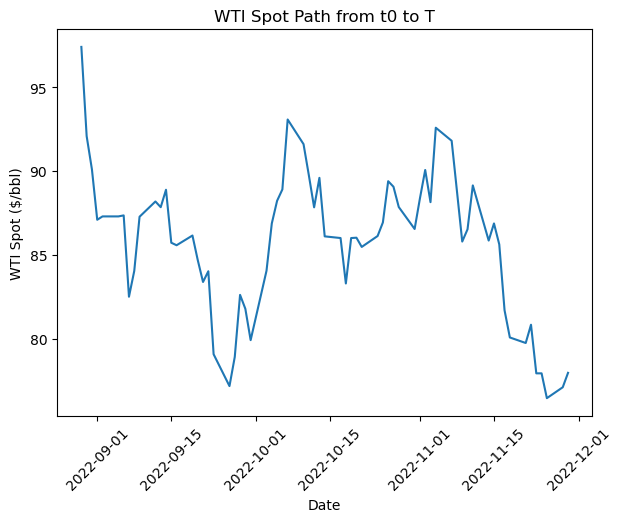

In [10]:
plt.figure()
plt.figure()
plt.plot(df_3mths["observation_dates"], df_3mths["price_per_barrel"])
plt.title("WTI Spot Path from t0 to T")
plt.xlabel("Date")
plt.ylabel("WTI Spot ($/bbl)")
plt.tight_layout()

# Rotate the x-axis labels
plt.xticks(rotation=45) 

plt.show()

In [11]:
# first value of WTI_Spot in the slice = S0
S_0 = df_3mths["price_per_barrel"].iloc[0]

# last value of WTI_Spot in the slice = ST
S_T = df_3mths["price_per_barrel"].iloc[-1]

print(f"S_0 = ${S_0}")
print(f"S_T = ${S_T}")

S_0 = $97.4
S_T = $77.96


We assume forward price = S_0.
Therefore, K = S_0 = 97.4

In [12]:
K = S_0

# P&L per barrel
pnl_per_barrel = K - S_T

# Scaling up to 5000 barrels 
total_barrels = 5000
pnl_total = total_barrels * pnl_per_barrel

print(f"K (Forward price): ${K:.2f}")
print(f"S_T (Spot at maturity): ${S_T:.2f}")
print(f"P&L per barrel (short forward): ${pnl_per_barrel:,.2f}")
print(f"P&L total (5,000 bbl): ${pnl_total:,.2f}")

K (Forward price): $97.40
S_T (Spot at maturity): $77.96
P&L per barrel (short forward): $19.44
P&L total (5,000 bbl): $97,200.00


In [13]:
# Comparing hedged and unhedged revenue 
print(f"Unhedged revenue: ${total_barrels * S_T:,.2f}")
print(f"Hedged revenue = ${total_barrels * K:,.2f}")

Unhedged revenue: $389,800.00
Hedged revenue = $487,000.00


In [14]:
97.4*5000

487000.0

Without a hedge, revenue declines because the oil price at maturity fell below the initial spot. By entering a short forward, the producer locked in the forward price and secured higher revenue despite the decline. The hedge effectively removed downside risk but also sacrificed potential upside had prices risen.

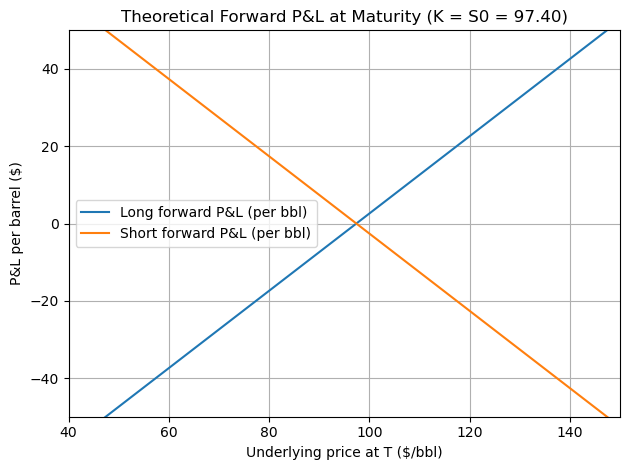

In [15]:
# Define x-axis: spot prices from 0 to 200
S_T_vals = np.linspace(0, 200, 400)

# Payoffs per barrel
pnl_long  = S_T_vals - K      # long forward payoff
pnl_short = K - S_T_vals      # short forward payoff

plt.figure()
plt.plot(S_T_vals, pnl_long, label="Long forward P&L (per bbl)")
plt.plot(S_T_vals, pnl_short, label="Short forward P&L (per bbl)")
plt.title(f"Theoretical Forward P&L at Maturity (K = S0 = {K:.2f})")
plt.xlabel("Underlying price at T ($/bbl)")
plt.ylabel("P&L per barrel ($)")
plt.legend()
plt.grid(True)

# Fixed axes for simplicity
plt.xlim(40, 150) 
plt.ylim(-50, 50) 

plt.tight_layout()
plt.show()

# Part B: Swaps

Swap terms: 
- Notional 100,000 gallons of WTI Crude
- Monthly Swap payments ($/g)-->(42g/barrel)
    - Heating Oil company pays a fixed amount, $1.99 to 3rd party(bank, intermediary)
    - Bank pays the average monthly oil price/gallon to the heating company(floating)
Tasks:
1. Convert the dollars-per-barrel to dollars-per-gallon(42 gallons per barrel). Create a new column.
2. Compute the average monthly $/G for each month
3. Compute the realized net payment for each month for both sides of the swap
    - plot the net payments for both parties vs time
4. Plot the theoretical P&L of the fixed-for-floating swap position

In [16]:
# --------- CONSTANTS ---------
NOTIONAL_GAL = 100000          # 100,000 gallons
FIXED_RATE_PER_GAL = 1.99       # $/gal paid by Heating Oil company (pays fixed)
BARREL_TO_GAL = 42.0            # 42 gallons per barrel

In [17]:
df['price_per_gallon'] = df['price_per_barrel'] / 42

In [18]:
df.head()

,observation_dates,price_per_barrel,price_per_gallon
0,2022-08-29,97.40,2.319048
1,2022-08-30,92.08,2.192381
2,2022-08-31,90.09,2.145000
3,2022-09-01,87.09,2.073571
4,2022-09-02,87.29,2.078333


In [19]:
# Creating new dataframe for monthly avg prices per gallon
monthly_avg = (
    df.groupby(pd.Grouper(key="observation_dates", freq="MS"))["price_per_gallon"]
      .mean()
      .rename("avg_per_gallon_by_mth")
      .reset_index()
)

In [20]:
monthly_avg

,observation_dates,avg_per_gallon_by_mth
0,2022-08-01,2.218810
1,2022-09-01,2.009426
2,2022-10-01,2.084637
3,2022-11-01,2.001851
4,2022-12-01,1.823323
5,2023-01-01,1.864199
6,2023-02-01,1.828726
7,2023-03-01,1.744710
8,2023-04-01,1.893071
9,2023-05-01,1.705041


In [21]:
# Creating dataframe for cashflows for each party
cashflows = monthly_avg.copy().rename(columns={"observation_dates": "month",
                                               "avg_per_gallon_by_mth": "avg_per_gallon_by_mth"})

# Net payments each month
cashflows["net_heating_company"] = (cashflows["avg_per_gallon_by_mth"] - FIXED_RATE_PER_GAL) * NOTIONAL_GAL
cashflows["net_bank"]            = -cashflows["net_heating_company"]


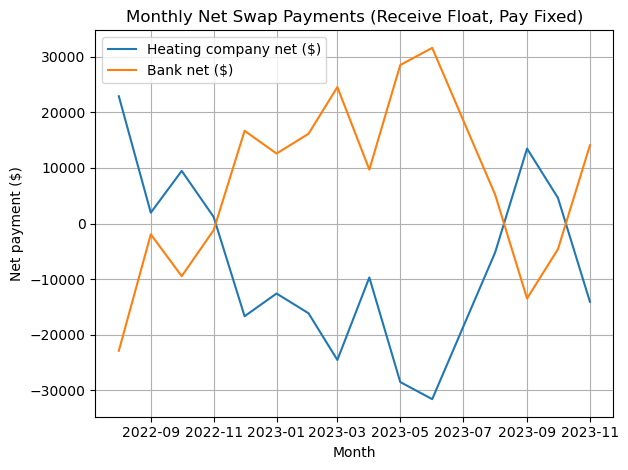

In [22]:
# Plot
plt.figure()
plt.plot(cashflows["month"], cashflows["net_heating_company"], label="Heating company net ($)")
plt.plot(cashflows["month"], cashflows["net_bank"], label="Bank net ($)")
plt.title("Monthly Net Swap Payments (Receive Float, Pay Fixed)")
plt.xlabel("Month")
plt.ylabel("Net payment ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

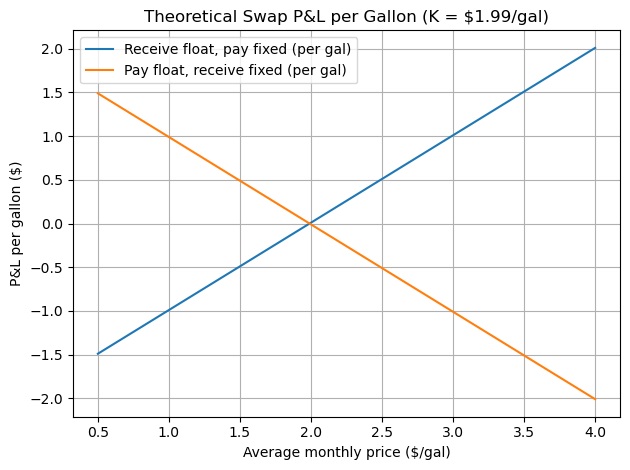

In [23]:
# Plotting theoretical PnL

# X-axis: possible average monthly prices ($/gal)
Sx = np.linspace(0.5, 4.0, 400)

# Per-gallon P&L
pnl_receiver_float_per_gal = Sx - FIXED_RATE_PER_GAL   # receive float, pay fixed
pnl_payer_float_per_gal  = FIXED_RATE_PER_GAL - Sx   # pay float, receive fixed


plt.figure()
plt.plot(Sx, pnl_receiver_float_per_gal, label="Receive float, pay fixed (per gal)")
plt.plot(Sx, pnl_payer_float_per_gal,  label="Pay float, receive fixed (per gal)")
plt.title(f"Theoretical Swap P&L per Gallon (K = ${FIXED_RATE_PER_GAL:.2f}/gal)")
plt.xlabel("Average monthly price ($/gal)")
plt.ylabel("P&L per gallon ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Part C: Options
 
Create Option Payoffs for the theoretical options:

A. Call:
- $S_0 = 100$
- $K = 105$
- Premium = $3
- T = 1 month
- What is Break-even price? 
- What is ROI if in 1 month, the underlying price = $110? 


B. Put: 
- $S_0 = 100$
- $K = 95$
- Premium = $2
- T = 1 month
- What is Break-even price?
- What is ROI if in 1 month, the underlying price = $92

In [24]:
def call_calc (S_T, C, K):
    # Payoff = cashflow from exercising the option at maturity
    payoff = max(S_T - K, 0)

    # Profit = payoff - premium 
    profit = payoff - C

    # Break-even price 
    break_even_price = K + C

    # ROI
    roi = profit * 100 / C

    return break_even_price, roi

In [25]:
S_T = 110 # Spot price of the underlying at expiration 
C = 3 # Call option premium 
K = 105 # Strike price

break_even_price, roi = call_calc(S_T, C, K)

print(f'Break-even price = ${break_even_price:.2f} \nROI = {roi:.2f}%')

Break-even price = $108.00 
ROI = 66.67%


In [26]:
def put_calc (S_T, P, K):
    # Payoff = cashflow from exercising the option at maturity
    payoff = max(K - S_T, 0)

    # Profit = payoff + premium 
    profit = payoff - P

    # Break-even price 
    break_even_price = K - P 

    # ROI
    roi = profit * 100 / P

    return break_even_price, roi

In [27]:
S_T = 92 # Spot price of the underlying at expiration 
P = 2 # Put option premium 
K = 95 # Strike price

break_even_price, roi = put_calc(S_T, P, K)

print(f'Break-even price = ${break_even_price:.2f} \nROI = {roi:.2f}%')

Break-even price = $93.00 
ROI = 50.00%


# Part D: Futures Margining & Daily Mark-to-Market — **Gold (Short 1 COMEX Contract)**

A trader goes **short one gold futures contract** on COMEX.

- **Contract size:** 100 troy ounces  
- **Entry price (Day 0):** $1,920 per ounce  
- **Initial margin:** $7,200  
- **Maintenance margin:** $6,500  

The futures position is **short** (the trader benefits if gold prices fall).  
At the end of each trading day, the contract is **marked to market (MTM)**.  
If the margin account falls **below maintenance**, the trader must **top up back to the initial margin level**.

**Settlement Prices (per ounce):**

| Day | Price ($) |
|-----|-----------|
| 0   | 1,920     |
| 1   | 1,915     |
| 2   | 1,940     |
| 3   | 1,925     |
| 4   | 1,910     |

**Tasks**  
1. **Daily MTM**: Compute the daily profit or loss (P/L) for Days 1–4 and track the margin account balance day by day.  
2. **Margin Calls**: Identify days when the balance falls below maintenance; compute the deposit needed to restore to the **initial margin**.  
3. **Final Outcome**: Compute total net P/L at Day 4 and verify with a cash-flow check.  
4. **Discussion**: Explain why a short faces margin calls when prices rise and how the clearinghouse ensures winners are paid.

In [28]:
def calculate_margin(df, contract_size, initial_margin, maintenance_margin):
    """
    To add daily_pnl, margin_balance, and margin_call columns
    to a dataframe of futures settlement prices.

    """
    # Daily price change
    df['price_change'] = df['settlement_price'].diff().fillna(0)
    
    # Daily PnL (short position)
    df['daily_pnl'] = -(df['price_change'] * contract_size)
    
    balance = [initial_margin]
    margin_call = [0]
    
    for i in range(1, len(df)):
        updated_balance = balance[-1] + df.loc[i, 'daily_pnl']
        
        if updated_balance < maintenance_margin:
            call_amt = initial_margin - updated_balance
            print(f'Margin call on day {i+1} for ${call_amt:,.2f}')
            margin_call.append(call_amt)
            updated_balance = initial_margin
        else:
            margin_call.append(0)
        
        balance.append(updated_balance)

    net_pnl = df['daily_pnl'].sum()
    print(f'Net P&L = ${net_pnl:,.2f}')
    
    df['margin_balance'] = balance
    df['margin_call'] = margin_call
    
    return df


In [29]:
df = pd.DataFrame({
    'day': [0, 1, 2, 3, 4],
    'settlement_price': [1920, 1915, 1940, 1925, 1910]
})

df = calculate_margin(df, contract_size=100, initial_margin=7200, maintenance_margin=6500)
print(df)

Margin call on day 3 for $2,000.00
Net P&L = $1,000.00
   day  settlement_price  price_change  daily_pnl  margin_balance  margin_call
0    0              1920           0.0       -0.0          7200.0          0.0
1    1              1915          -5.0      500.0          7700.0          0.0
2    2              1940          25.0    -2500.0          7200.0       2000.0
3    3              1925         -15.0     1500.0          8700.0          0.0
4    4              1910         -15.0     1500.0         10200.0          0.0


## Discussion

When a trader is short a futures contract, they benefit if prices fall.

- If prices instead rise, the short position loses money (because the trader will have to buy back at a higher price than they sold).
- Each day the contract is marked to market, so losses are deducted from the short’s margin account.
- If these losses push the balance below the maintenance margin, the trader receives a margin call and they must deposit additional funds to restore the account to the initial margin level.

The clearinghouse plays the central role:

- It stands between buyers and sellers (becoming the counterparty to every trade).
- It guarantees that winners are always paid, by transferring funds daily from losing accounts (like the short when prices rise) to winning accounts (the longs).
- This daily settlement process (variation margin) prevents the accumulation of large unpaid losses and ensures the system’s integrity.